In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms
import torch.utils.data as data
from torch.utils.data.dataset import Dataset
from torchvision.models.resnet import ResNet, BasicBlock
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage.color import rgb2gray
%matplotlib inline

from sklearn import metrics
import matplotlib.image as mpimg
import random
from scipy import interp
from itertools import cycle


import cv2
import numpy as np
from skimage import io 
from skimage.transform import rotate, AffineTransform, warp
import matplotlib.pyplot as plt
import random
from skimage import img_as_ubyte
import os
from skimage.util import random_noise

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##MNIST

In [0]:
data_raw = pd.read_csv("drive/My Drive/sign_mnist_train.csv")
test_data_raw = test = pd.read_csv("drive/My Drive/sign_mnist_test.csv")

In [0]:
# Break up data and labels
labels = data_raw['label']
data_raw.drop('label', axis=1, inplace=True)
labels_test = test_data_raw['label']
test_data_raw.drop('label', axis=1, inplace=True)

# Normalize data
data_full = data_raw.values/255
labels_full = labels.values
test_data_full = test_data_raw.values/255 
labels_test_full = labels_test.values 

# Concatenate training and test set
X_MNIST_full = np.concatenate((data_full, test_data_full))
y_MNIST_full = np.concatenate((labels_full,labels_test_full))

# Get rid of unused letters and the letters c, g, and h
X_MNIST = []
y_MNIST = []
for i in range(len(y_MNIST_full)):
  if (y_MNIST_full[i] <= 8 and y_MNIST_full[i] != 2 and y_MNIST_full[i] != 6 and y_MNIST_full[i] != 7): #ADDED THE LAST AND STATEMENT TO GET RID OF I's
    X_MNIST.append(X_MNIST_full[i])
    y_MNIST.append(y_MNIST_full[i])
X_MNIST = np.asarray(X_MNIST)
y_MNIST = np.asarray(y_MNIST)

# Reshape data to 50x50
X_MNIST_50 = []
for i in range (len(X_MNIST)):
  img_flat_orig = X_MNIST[i];
  img_2d_orig = img_flat_orig.reshape(28, 28)
  img_2d_new = cv2.resize(img_2d_orig, dsize=(50,50), interpolation=cv2.INTER_CUBIC)
  img_1d_new = img_2d_new.flatten()
  X_MNIST_50.append(img_1d_new)
X_MNIST_50 = np.asarray(X_MNIST_50)

In [4]:
X_MNIST_50.shape

(8696, 2500)

##Class

In [0]:
X_class_orig = np.load('drive/My Drive/train_data.npy')
y_class_orig = np.load('drive/My Drive/train_labels.npy')

In [0]:
C_data = np.load('drive/My Drive/C/data.npy')
C_labels = np.load('drive/My Drive/C/labels.npy')

In [0]:
C_labels.resize(709,1)

In [0]:
X_class_raw = np.concatenate((X_class_orig, C_data))
y_class_raw = np.concatenate((y_class_orig, C_labels))

In [0]:
# Change letters to numbers
letters = {'A': 0, 'B': 1,'C': 2, 'D': 3,'E': 4, 
                        'F': 5,'G': 6, 'H': 7,'I': 8}
y_class = []
for i in range(len(y_class_raw)):
  y_class.append(letters[y_class_raw[i][0]])
y_class = np.asarray(y_class)

# Normalize and format data
X_class = []
for i in range(X_class_raw.shape[0]):
  img = X_class_raw[i]
  img_r = cv2.resize(img, dsize=(50,50), interpolation=cv2.INTER_CUBIC)
  img_g = rgb2gray(img_r)
  img_1d = img_g.flatten()
  X_class.append(img_1d)
X_class = np.asarray(X_class)

In [0]:
# Change letters to numbers
letters = {'A': 0, 'B': 1,'C': 2, 'D': 3,'E': 4, 
                        'F': 5,'G': 6, 'H': 7,'I': 8}
y_class_otest = []
for i in range(len(y_class_orig)):
  y_class_otest.append(letters[y_class_orig[i][0]])
y_class_otest = np.asarray(y_class_otest)

# Normalize and format data
X_class_otest = []
for i in range(X_class_orig.shape[0]):
  img = X_class_orig[i]
  img_r = cv2.resize(img, dsize=(50,50), interpolation=cv2.INTER_CUBIC)
  img_g = rgb2gray(img_r)
  img_1d = img_g.flatten()
  X_class_otest.append(img_1d)
X_class_otest = np.asarray(X_class_otest)

In [12]:
X_train_class, X_test_orig_class, y_train_class, y_test_orig_class = train_test_split(
    X_class_otest, y_class_otest, test_size=0.6, random_state=4)
X_test_orig_class.shape, y_test_orig_class.shape

((1107, 2500), (1107,))

##Combine Class and MNIST

In [13]:
X = np.concatenate((X_MNIST_50, X_class))
y = np.concatenate((y_MNIST, y_class))
X.shape, y.shape

((11249, 2500), (11249,))

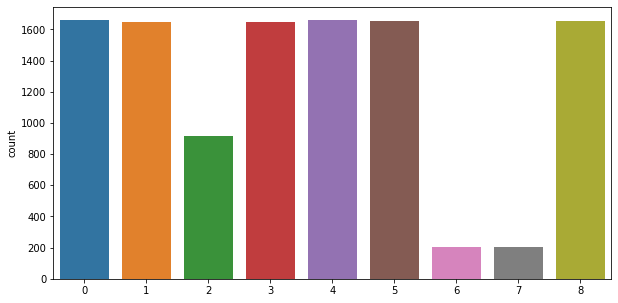

In [14]:
plt.figure(figsize = (10,5))
sns.countplot(x = y);

##Data Augmentation

In [0]:
# https://towardsdatascience.com/image-augmentation-using-python-numpy-opencv-and-skimage-ef027e9898da
def anticlockwise_rotation(image):
    angle= random.randint(0,8)
    return rotate(image, angle)

def clockwise_rotation(image):
    angle= random.randint(0,8)
    return rotate(image, -angle)

def h_flip(image):
    return  np.fliplr(image)

def v_flip(image):
    return np.flipud(image)

def add_noise(image):
    return random_noise(image)

def blur_image(image):
    return cv2.GaussianBlur(img, (9,9),0)

def warp_shift(image): 
    transform = AffineTransform(translation=(0,40)) 
    warp_image = warp(image, transform, mode="wrap")
    return warp_image

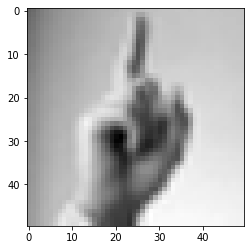

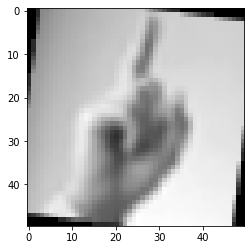

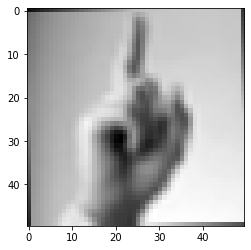

In [16]:
img = X_MNIST_50[0]
img = img.reshape(50,50)
img.shape
plt.imshow(img, cmap='gray'); plt.show();
img_rot = clockwise_rotation(img)
plt.imshow(img_rot, cmap='gray'); plt.show();
img_rot2 = rotate(img, random.uniform(0,5))
plt.imshow(img_rot2, cmap='gray'); plt.show();

In [0]:
X_MNIST_50.shape

(8696, 2500)

In [18]:
transformations = {'rotate anticlockwise': anticlockwise_rotation,
                      'rotate clockwise': clockwise_rotation,
                      'horizontal flip': h_flip, 
                      'vertical flip': v_flip,
                   'warp shift': warp_shift,
                   'adding noise': add_noise}

X_new = []
y_new = []
X_using = X
y_using = y

# Lets data augment 4,000 photos, and C by an extra 800 to match the others

index_of_C = []
for i in range(len(y_using)):
  if(y_using[i] == 2):
    #print(i)
    index_of_C.append(i)
img_of_C = 800
for i in range(1, img_of_C+1):
  idx = random.choice(index_of_C)
  y_new.append(y_using[idx])
  original_image = X_using[idx].reshape(50,50)
  transformed_image=None
  n = 0       #variable to iterate till number of transformation to apply
  transformation_count = random.randint(1, len(transformations)) #choose random number of transformation to apply on the image
  #print("trans count: ",transformation_count)
  while n <= transformation_count:
      key = random.choice(list(transformations)) #randomly choosing method to call
      #print(key)
      transformed_image = transformations[key](original_image)  
      #print(transformed_image.shape)
      n = n + 1 
  #print(transformed_image.shape)    
  trans_img = transformed_image.flatten()
  X_new.append(trans_img);


index_of_G = []
for i in range(len(y_using)):
  if(y_using[i] == 6):
    #print(i)
    index_of_G.append(i)
img_of_G = 2000
for i in range(1, img_of_G+1):
  idx = random.choice(index_of_G)
  y_new.append(y_using[idx])
  original_image = X_using[idx].reshape(50,50)
  transformed_image=None
  n = 0       #variable to iterate till number of transformation to apply
  transformation_count = random.randint(1, len(transformations)) #choose random number of transformation to apply on the image
  #print("trans count: ",transformation_count)
  while n <= transformation_count:
      key = random.choice(list(transformations)) #randomly choosing method to call
      #print(key)
      transformed_image = transformations[key](original_image)  
      #print(transformed_image.shape)
      n = n + 1 
  #print(transformed_image.shape)    
  trans_img = transformed_image.flatten()
  X_new.append(trans_img);


index_of_H = []
for i in range(len(y_using)):
  if(y_using[i] == 7):
    #print(i)
    index_of_H.append(i)
img_of_H = 2000
for i in range(1, img_of_H+1):
  idx = random.choice(index_of_H)
  y_new.append(y_using[idx])
  original_image = X_using[idx].reshape(50,50)
  transformed_image=None
  n = 0       #variable to iterate till number of transformation to apply
  transformation_count = random.randint(1, len(transformations)) #choose random number of transformation to apply on the image
  #print("trans count: ",transformation_count)
  while n <= transformation_count:
      key = random.choice(list(transformations)) #randomly choosing method to call
      #print(key)
      transformed_image = transformations[key](original_image)  
      #print(transformed_image.shape)
      n = n + 1 
  #print(transformed_image.shape)    
  trans_img = transformed_image.flatten()
  X_new.append(trans_img);
  
images_to_generate = 4000
i = 1
while i <= images_to_generate:
  img_idx = random.randint(0, len(X_using)-1)
  y_new.append(y_using[img_idx])
  original_image = X_using[img_idx].reshape(50,50)
  transformed_image=None
  n = 0       #variable to iterate till number of transformation to apply
  transformation_count = random.randint(1, len(transformations)) #choose random number of transformation to apply on the image
      
  while n <= transformation_count:
      key = random.choice(list(transformations)) #randomly choosing method to call
      transformed_image = transformations[key](original_image)
      n = n + 1
          
  trans_img = transformed_image.flatten()
  X_new.append(trans_img);
  i += 1
#plt.imshow(transformed_image, cmap = 'gray')
X_new = np.asarray(X_new)
y_new = np.asarray(y_new)
X_new.shape, y_new.shape

((8800, 2500), (8800,))

In [19]:
X = np.concatenate((X, X_new))
y = np.concatenate((y, y_new))
X.shape, y.shape

((20049, 2500), (20049,))

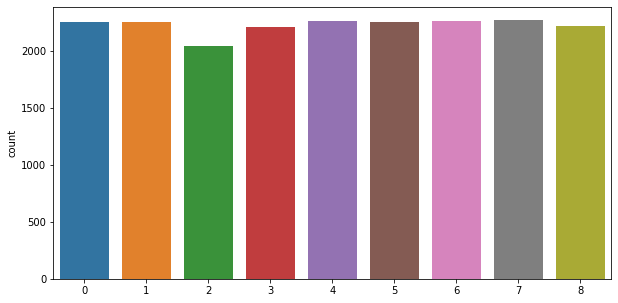

In [20]:
plt.figure(figsize = (10,5))
sns.countplot(x = y);

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((16039, 2500), (16039,), (4010, 2500), (4010,))

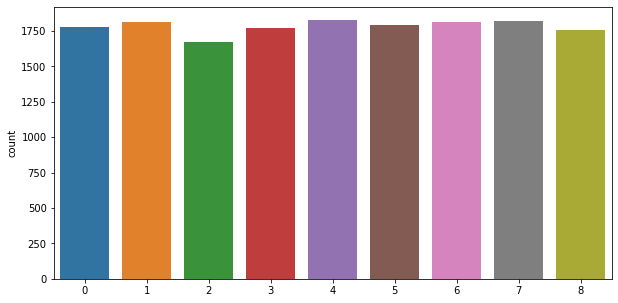

In [37]:
plt.figure(figsize = (10,5))
sns.countplot(x = y_train);

In [0]:
# https://www.kaggle.com/justuser/sign-language-classifier-convnet-with-pytorch
 class Network(nn.Module):   
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(20, 30, 3) 
        self.dropout1 = nn.Dropout2d()
        
        self.fc3 = nn.Linear(30*9*9, 270) 
        self.fc4 = nn.Linear(270, 9) 
        
        self.softmax = nn.LogSoftmax(dim=1)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout1(x)
                
        x = x.view(-1, 30 * 9 * 9) 
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        return self.softmax(x)
    
    
    def test(self, predictions, labels):
        
        self.eval()
        correct = 0
        for p, l in zip(predictions, labels):
            if p == l:
                correct += 1
        
        acc = correct / len(predictions)
        print("Correct predictions: %5d / %5d (%5f)" % (correct, len(predictions), acc))
        
    
    def evaluate(self, predictions, labels):
                
        correct = 0
        for p, l in zip(predictions, labels):
            if p == l:
                correct += 1
        
        acc = correct / len(predictions)
        return(acc)

In [0]:
def convert_2d(data, dim):
    data_new = []
    for i in data:
        data_new.append(i.reshape(1, dim, dim))
    return np.array(data_new)

In [0]:
X_train_2d = convert_2d(X_train, 50)
X = torch.FloatTensor(X_train_2d)
y = torch.LongTensor(y_train.tolist())

X_test_2d = convert_2d(X_test, 50)
X_test_full = torch.FloatTensor(X_test_2d)
y_test_full = torch.LongTensor(y_test.tolist())

In [26]:
net = Network()
print(net)

Network(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (fc3): Linear(in_features=2430, out_features=270, bias=True)
  (fc4): Linear(in_features=270, out_features=9, bias=True)
  (softmax): LogSoftmax()
)


In [0]:
epochs = 30
batch_size = 100
learning_rate = 0.08

In [0]:
optimizer = optim.SGD(net.parameters(), learning_rate, momentum=0.7)
loss_func = nn.CrossEntropyLoss()

In [29]:
net.train()
loss_log = []
acc_log = []
import datetime 
for e in range(epochs):
    for i in range(0, X.shape[0], batch_size):
        X_batch = X[i:i + batch_size] 
        y_batch = y[i:i + batch_size] 
        
        optimizer.zero_grad()
        net_out = net(Variable(X_batch))
        
        loss = loss_func(net_out, Variable(y_batch))
        loss.backward()
        optimizer.step()
        
        if i % 1000 == 0:
            #pred = net(Variable(test_data_formated))
            loss_log.append(loss.item())
            acc_log.append(net.evaluate(torch.max(net(Variable(X_test_full[:500])).data, 1)[1], 
                                        y_test_full[:500]))
        
    print('Epoch: {} - Loss: {:.6f}'.format(e + 1, loss.item()))

Epoch: 1 - Loss: 1.557836
Epoch: 2 - Loss: 0.477060
Epoch: 3 - Loss: 0.594258
Epoch: 4 - Loss: 0.417350
Epoch: 5 - Loss: 0.310791
Epoch: 6 - Loss: 0.207549
Epoch: 7 - Loss: 0.107797
Epoch: 8 - Loss: 0.073798
Epoch: 9 - Loss: 0.054647
Epoch: 10 - Loss: 0.024975
Epoch: 11 - Loss: 0.040168
Epoch: 12 - Loss: 0.083202
Epoch: 13 - Loss: 0.011570
Epoch: 14 - Loss: 0.057301
Epoch: 15 - Loss: 0.002665
Epoch: 16 - Loss: 0.042258
Epoch: 17 - Loss: 0.004053
Epoch: 18 - Loss: 0.001089
Epoch: 19 - Loss: 0.002736
Epoch: 20 - Loss: 0.000298
Epoch: 21 - Loss: 0.083048
Epoch: 22 - Loss: 0.018525
Epoch: 23 - Loss: 0.002661
Epoch: 24 - Loss: 0.015753
Epoch: 25 - Loss: 0.001358
Epoch: 26 - Loss: 0.083643
Epoch: 27 - Loss: 0.007030
Epoch: 28 - Loss: 0.000600
Epoch: 29 - Loss: 0.000052
Epoch: 30 - Loss: 0.000118


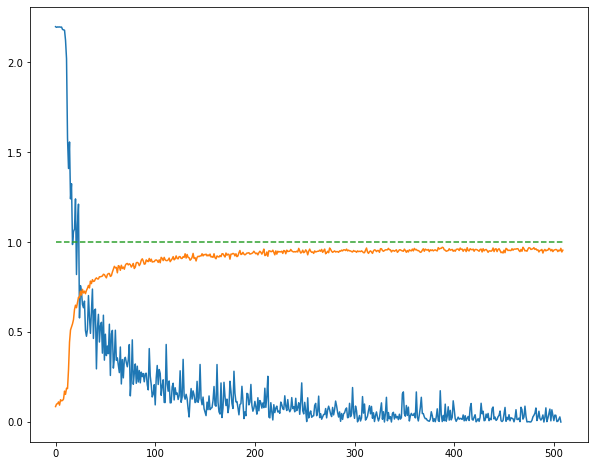

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,8))
plt.plot(loss_log[2:])
plt.plot(acc_log)
plt.plot(np.ones(len(acc_log)), linestyle='dashed')

In [31]:
# Testing against combined dataset
net.eval()
predictions = net(Variable(X_test_full))
net.test(torch.max(predictions.data, 1)[1], y_test_full)

Correct predictions:  3907 /  4010 (0.974314)


In [0]:
def convert2DTo1D(arr):
    if (len(arr) == 0):
        return;
    temp = np.array(arr[0]);
    for i in range(1,len(arr)):
        temp = np.append(temp, arr[i]);
    return temp

#Convert all the photos into 1D arrays
def convertAllPhotosTo1DArrays(threeDArr):
    if (len(threeDArr.shape) < 2):
        print("Array size is not 3D")
        return threeDArr;
    twoDArr = np.zeros(shape=(len(threeDArr),10000))
    for i in range(len(threeDArr)):
        twoDArr[i] = convert2DTo1D(threeDArr[i])
    return twoDArr

#Calculates the accuracy for each class
def createAccuracyPerClassArray(y_actual, y_predict, labels):
    correct = [0] * len(labels)
    total = [0] * len(labels)
    for i in range(len(y_actual)):
        if y_actual[i] == y_predict[i]:
            correct[labels.index(y_actual[i])] += 1
        total[labels.index(y_actual[i])] += 1
    accuracy = [0] * len(labels)
    for i in range(len(correct)):
        if (total[i] == 0):
          accuracy[i] = 0
        else:
          accuracy[i] = correct[i] / total[i]
    return accuracy

def makeAccuracyGraph(arr, training, startingNum=0, title=""):
    plt.figure(figsize=(10,6))
    plt.plot(range(startingNum, startingNum + len(arr)),arr,color='blue', linestyle='dashed', marker="o",
            markerfacecolor='red', markersize=10, label="Test")
    plt.plot(range(startingNum, startingNum + len(arr)),arr,color='green', linestyle='-.', marker="o",
            markerfacecolor='purple', markersize=10, label="Training")
    plt.title("Accuracy vs" + title)
    plt.xlabel(title)
    plt.ylabel("Accuracy")

#Prints the perclass accuracy
def printPerClassAccuracies(accuracy, labels, title=""):
      for i in range(len(accuracy)):
        print(title, " ", labels[i], " accuracy: ", accuracy[i])
    
#Prints the overall accuracy and the per class accuracy for each N 
#(for example, if I were testing K different neighbors for KNN, the arr would be len(K), the perClass would be a 2D array with [K, len(labels)])
def printAccuracies(arr, training, perClass, labels, startingNum = 0, title=""):
    for i in range(len(arr)):
        print(title, " - ", startingNum+i, " overall accuracy: ", arr[i])
        print("Per class accuracies for ", title, startingNum+i)
        printPerClassAccuracies(perClass[i],labels)

    makeAccuracyGraph(arr, training, startingNum, title)

#Metrics function
def performMetrics(y_te, y_pre, labels, name=""):
    y_test = [-1] * y_te.shape[0] #Create a N sized array, where N is the size of the training set
    i_max = -1000
    for i in range(len(y_te)):
      i_max = -1
      for j in range(len(y_te[i])): 
        if y_te[i][j] > i_max:
          i_max = y_te[i][j]
          y_test[i] = j
      #JD6 We could easily just test here that if it is less than a threshold leave it at -1
      #y_test[i] = j #if i_max < threshold

    y_predict = y_pre.tolist()

    #Converting them to be the letters
    for i in range(len(y_predict)):
      y_test[i] = labels[y_test[i]]
      y_predict[i] = labels[y_predict[i]]

    count = 0
    for i in range(len(y_test)):
        count += 1 if (y_test[i] == y_predict[i]) else 0
    print(name, " Overall average: ", (count/len(y_test)))

    perClass = createAccuracyPerClassArray(y_test,y_predict,labels)
    printPerClassAccuracies(perClass, labels, name)

    #Confusion Maxtrix - Lecture 10
    C = metrics.confusion_matrix(y_test,y_predict,labels=labels)
    print(C)
    C_scaled = list()
    #Scaling each value
    #JD6, may have to put an array of possible labels here?
    for row in range(0,len(C)):
        total = 0
        C_scaled.append(list())
        for col in range(0,len(C[row])):
            total += C[row][col] 
        for col in range(0,len(C[row])):
            C_scaled [row].append(C[row][col] / total) 
            #Divide each one to get the %

    plt.figure(figsize = (15,15))
    ax = plt.axes()
    sns.heatmap(C_scaled, annot=True)

    ax.set_title("Confusion matrix -" + name)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    plt.show()

    #Taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    # Compute ROC curve and ROC area for each class
    lw = 2
    n_classes = len(labels)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        #From Dr. Silvia's OH
        y_t = [True] * len(y_test)
        y_p = [True] * len(y_test)
        for j in range(len(y_test)):
          y_t[j] = 1 if (y_test[j] == labels[i]) else 0
          y_p[j] = 1 if (y_predict[j] == labels[i]) else 0
        fpr[labels[i]], tpr[labels[i]], _ = metrics.roc_curve(y_t, y_p)
        roc_auc[labels[i]] = metrics.auc(fpr[labels[i]], tpr[labels[i]])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[labels[i]] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[labels[i]], tpr[labels[i]])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()

    plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', "y", "k", "g", "r", "m", "b", "c"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[labels[i]], tpr[labels[i]], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(labels[i], roc_auc[labels[i]]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for each digit')
    plt.legend(loc="lower right")
    plt.show()

Correct predictions:  3907 /  4010 (0.974314)
CNN for Full test set  Overall average:  0.9748129675810474
CNN for Full test set   A  accuracy:  0.9870410367170627
CNN for Full test set   B  accuracy:  0.9816933638443935
CNN for Full test set   C  accuracy:  0.968
CNN for Full test set   D  accuracy:  0.9861751152073732
CNN for Full test set   E  accuracy:  0.9683972911963883
CNN for Full test set   F  accuracy:  0.9867549668874173
CNN for Full test set   G  accuracy:  0.9823788546255506
CNN for Full test set   H  accuracy:  0.9635193133047211
CNN for Full test set   I  accuracy:  0.9505154639175257
[[457   1   1   0   2   0   1   1   0]
 [  1 429   3   0   1   3   0   0   0]
 [  1   4 363   3   1   3   0   0   0]
 [  1   1   1 428   0   3   0   0   0]
 [  3   1   4   2 429   2   0   0   2]
 [  0   4   0   1   0 447   0   0   1]
 [  0   0   2   0   1   1 446   1   3]
 [  3   0   1   0   0   3  10 449   0]
 [ 11   1   1   4   2   5   0   0 461]]


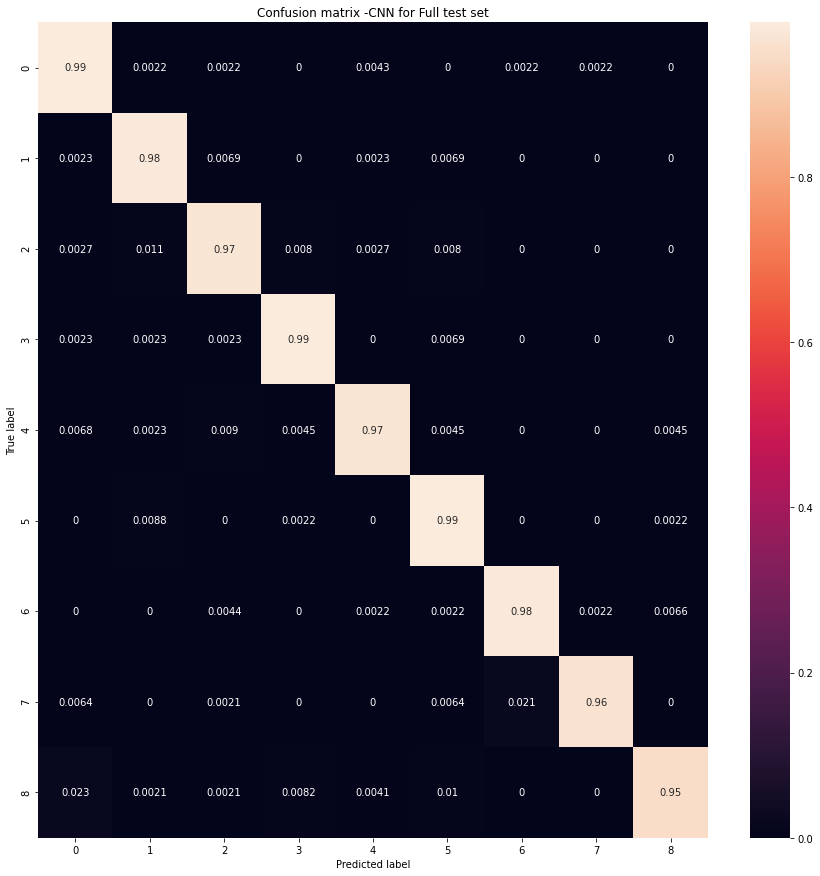

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:135: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


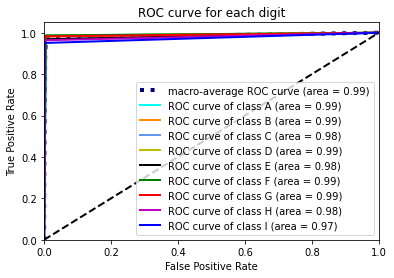

In [33]:
possibleLabels = ["A", "B", "C", "D", "E", "F", "G", "H", "I"]
predictions = net(Variable(X_test_full))

net.test(torch.max(predictions.data, 1)[1], y_test_full)
#predictions.data.shape, y_test_full.shape
performMetrics(predictions.data, y_test_full, possibleLabels, "CNN for Full test set")

Correct predictions:  1061 /  1107 (0.958446)
CNN for Class test set  Overall average:  0.959349593495935
CNN for Class test set   A  accuracy:  1.0
CNN for Class test set   B  accuracy:  0.9834710743801653
CNN for Class test set   C  accuracy:  0.984251968503937
CNN for Class test set   D  accuracy:  0.9912280701754386
CNN for Class test set   E  accuracy:  0.9606299212598425
CNN for Class test set   F  accuracy:  0.9734513274336283
CNN for Class test set   G  accuracy:  1.0
CNN for Class test set   H  accuracy:  1.0
CNN for Class test set   I  accuracy:  0.7894736842105263
[[103   0   0   0   0   0   0   0   0]
 [  1 119   0   0   0   1   0   0   0]
 [  0   1 125   0   1   0   0   0   0]
 [  1   0   0 113   0   0   0   0   0]
 [  0   0   2   1 122   1   0   0   1]
 [  0   1   0   1   0 110   0   0   1]
 [  0   0   0   0   0   0 137   0   0]
 [  0   0   0   0   0   0   0 113   0]
 [ 18   5   1   1   5   2   0   0 120]]


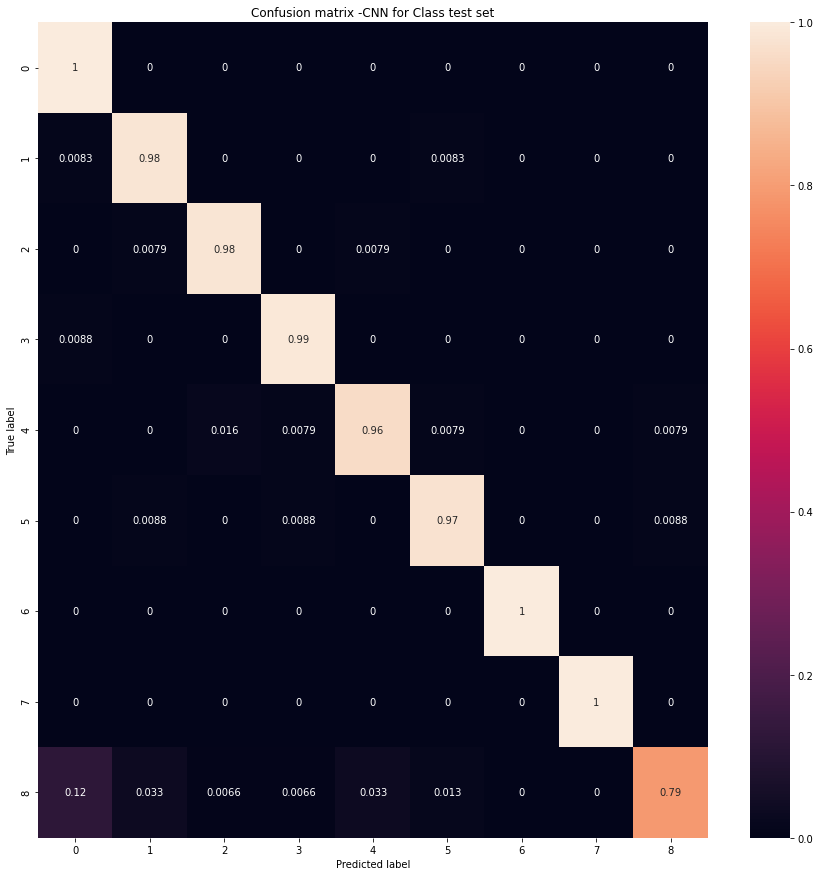

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:135: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


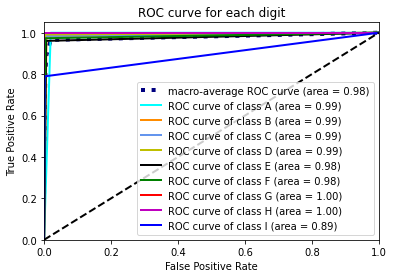

In [34]:
# Testing against class dataset
X_test_2d = convert_2d(X_test_orig_class, 50)
X_class_test = torch.FloatTensor(X_test_2d)
y_class_test = torch.LongTensor(y_test_orig_class.tolist())

predictions = net(Variable(X_class_test))
net.test(torch.max(predictions.data, 1)[1], y_class_test)
performMetrics(predictions.data, y_class_test, possibleLabels, "CNN for Class test set")

In [0]:
torch.save(net.state_dict(), 'drive/My Drive/model_wFullDataAug_40Train.pth')

##Loading with PyTorch

In [0]:
model = Network()
model.load_state_dict(torch.load('drive/My Drive/model_wFullDataAug.pth'))
model.eval()

Network(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (fc3): Linear(in_features=2430, out_features=270, bias=True)
  (fc4): Linear(in_features=270, out_features=9, bias=True)
  (softmax): LogSoftmax()
)

Correct predictions:   526 /   554 (0.949458)
CNN for Class test set  Overall average:  0.9494584837545126
CNN for Class test set   A  accuracy:  0.9814814814814815
CNN for Class test set   B  accuracy:  1.0
CNN for Class test set   C  accuracy:  0.9833333333333333
CNN for Class test set   D  accuracy:  1.0
CNN for Class test set   E  accuracy:  0.9552238805970149
CNN for Class test set   F  accuracy:  0.9807692307692307
CNN for Class test set   G  accuracy:  0.9861111111111112
CNN for Class test set   H  accuracy:  1.0
CNN for Class test set   I  accuracy:  0.7586206896551724
[[53  0  0  0  1  0  0  0  0]
 [ 0 61  0  0  0  0  0  0  0]
 [ 0  0 59  0  0  1  0  0  0]
 [ 0  0  0 54  0  0  0  0  0]
 [ 0  1  0  1 64  0  0  0  1]
 [ 0  0  0  0  0 51  0  0  1]
 [ 0  0  0  0  1  0 71  0  0]
 [ 0  0  0  0  0  0  0 47  0]
 [12  4  0  1  4  0  0  0 66]]


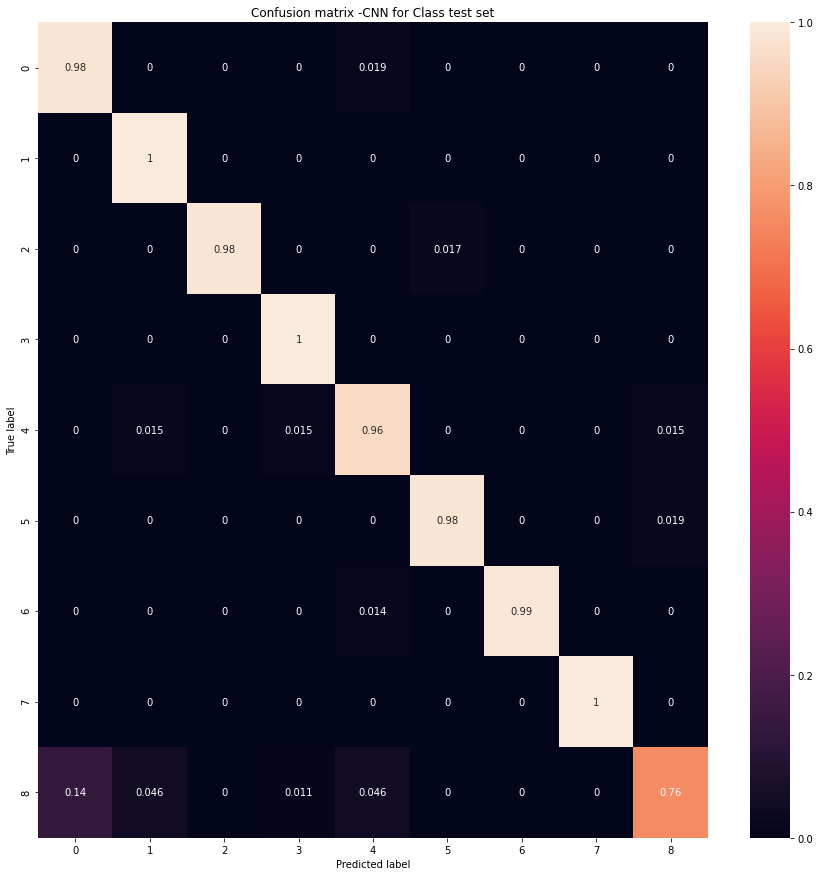

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:135: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


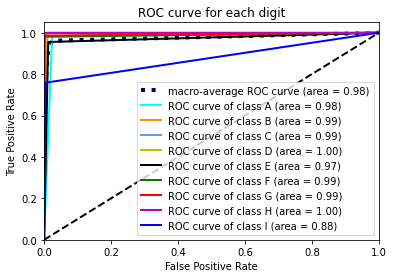

In [0]:
possibleLabels = ["A", "B", "C", "D", "E", "F", "G", "H", "I"]
X_test_2d = convert_2d(X_test_orig_class, 50)
X_class_test = torch.FloatTensor(X_test_2d)
y_class_test = torch.LongTensor(y_test_orig_class.tolist())

predictions = model(Variable(X_class_test))
model.test(torch.max(predictions.data, 1)[1], y_class_test)
performMetrics(predictions.data, y_class_test, possibleLabels, "CNN for Class test set")